# 02: Identifying Power Outages Using Social Media - Data Cleaning, Word2Vec Model, Outage Sentiment
### Danielle Medellin, Matthew Malone, Omar Smiley

## Import Libraries

In [5]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import numpy as n
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

## Load in Datasets

In [6]:
# bring in each data set for each state

cali = pd.read_csv('../data/scrape_dm_cali.csv')

mich = pd.read_csv('../data/scrape_dm_mich.csv')

ny = pd.read_csv('../data/scrape_dm_ny.csv')

ohio = pd.read_csv('../data/scrape_dm_ohio.csv')

texas = pd.read_csv('../data/scrape_dm_texas.csv')

# concatenate datasets to one dataframe 
tweets = pd.concat([cali, mich, ny, ohio, texas])

tweets.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start
0,710245730590404608,TTWN SF Bay Area,Power outage in Cupertino #BayArea #Traffic ht...,2016-03-16 23:25:52,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
1,708811502241734656,San Jose Now,WEATHER ALERT: Flash flood watch in Bay Area a...,2016-03-13 00:26:45,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
2,706856719733776384,San Jose Now,Power outages:30 in San Francisco154 on Penins...,2016-03-07 14:59:09,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
3,726876023573204993,San Jose Now,Power outage in Fremont. Several intersections...,2016-05-01 20:48:43,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
4,724681945095888897,San Jose Now,"East Bay power outages also affects BART, UC B...",2016-04-25 19:30:14,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01


The 5 datasets for each state were loaded in and combined into a `tweets` dataset. 

## Data Cleaning

In [7]:
tweets.shape

(20100, 10)

In [8]:
# drop duplicates 
tweets.drop_duplicates(inplace=True)

In [9]:
tweets.shape

(16913, 10)

In [10]:
# reset index 
tweets.reset_index(inplace= True, drop = True)

In [11]:
tweets.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start
0,710245730590404608,TTWN SF Bay Area,Power outage in Cupertino #BayArea #Traffic ht...,2016-03-16 23:25:52,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
1,708811502241734656,San Jose Now,WEATHER ALERT: Flash flood watch in Bay Area a...,2016-03-13 00:26:45,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
2,706856719733776384,San Jose Now,Power outages:30 in San Francisco154 on Penins...,2016-03-07 14:59:09,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
3,726876023573204993,San Jose Now,Power outage in Fremont. Several intersections...,2016-05-01 20:48:43,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
4,724681945095888897,San Jose Now,"East Bay power outages also affects BART, UC B...",2016-04-25 19:30:14,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01


In [12]:
tweets.isnull().sum()

tweet_id       0
username       0
text           0
tweet_date     0
search_term    0
city           0
lat            0
long           0
radius         0
query_start    0
dtype: int64

There are no null values in the dataset. 

## Function to clean tweets & usernames

In [13]:
def clean_str(string):
    string = string.lower()
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    string = re.sub(url_pattern, ' ', string)
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]+", "", string)
    string = re.sub(r'[^\w\s]','', string)    
    
    return string.strip()

In [14]:
tweets['text'] = tweets['text'].map(clean_str) # clean tweets
tweets['username'] = tweets['username'].map(clean_str) # clean username

In [15]:
# making new column with username + tweet
tweets['name_and_tweet'] = tweets['username'] + " " +tweets['text']

The above code cleans each tweet, removing any character that is not a letter, removes links, makes all text lowercase, and removes emojis. We ran that cleaning function on the text from the tweets (`text`) and the `username` for each tweet. We then created a new column that includes the username and the tweet. 

## CountVectorizer

In [17]:
cv_tweets = CountVectorizer(stop_words = 'english')
tweet_words = cv_tweets.fit_transform(tweets['name_and_tweet'])

cv_tweets = pd.DataFrame(tweet_words.todense(), columns=cv_tweets.get_feature_names())

In [18]:
top_twenty_words = cv_tweets.sum().sort_values().tail(20)

In [24]:
top_twenty_words.tail()

electric     1573
just         1609
lights       2081
light        2927
power       10476
dtype: int64

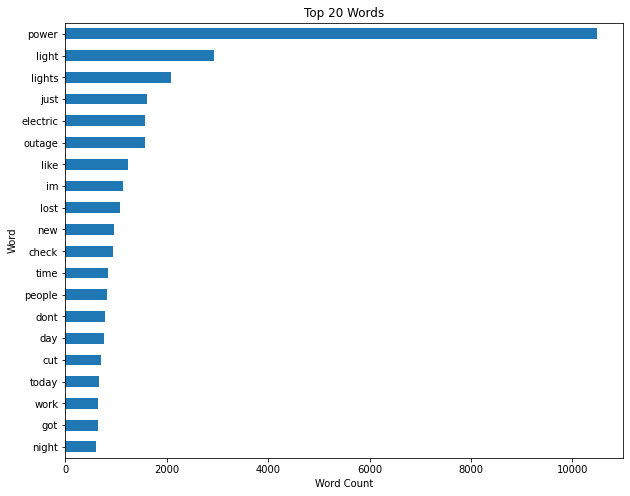

In [21]:
plt.figure(figsize=(10,8))

top_twenty_words.plot(kind='barh')
plt.title('Top 20 Words')
plt.xlabel('Word Count')
plt.ylabel('Word');

We used CountVectorizer to get a word count to analyze the most frequently occuring words in the tweets we scraped. This allowed us to gain a better understanding of the key words related to our word and word phrase searches when we originally scraped tweets from Twitter. Once these words were identified we could start to assess the words most associated with the most frequently occuring words. 

## Word2Vec Model

In [425]:
# turning cleaned tweets into list of lists

def tweet_to_words(tweets):
    # empty list of tweets
    list_of_tweets = []
    
    # make tweet into list of words
    for tweet in tweets:
        tweet = tweet.split()
    
        # list of stop words
        stops = ['los','angeles','san','diego','jose','columbus','cleveland',
             'cincinatti','detroit','ann','arbor','warren','new','york',
             'ny','buffalo','rochester','michigan','california','ohio','texas',
            'st','amc','scott','schudlich','finnished','de','antonio','la','houston',
                 'dallas', 'santa', 'ana', 'clara', 'grand', 'rapids', 'kearny','mesa',
                'peticolas','christmas']
    
        # Remove stopwords.
        meaningful_tweet = [w for w in tweet if not w in stops]
    
        # add tweet to big list
        list_of_tweets.append(meaningful_tweet)

    return list_of_tweets

A stop words list was created through an iterative process with the Word2Vec model. We looked at the most closely associated words to our `search_terms` and took out words that were not relevant or associated to a different meaning of the word.

For example, we took out all words associated with the cities/locations, because they didn't directly impact the meaning of a tweet and its discussion of a power outage. 

Another example is the word _peticolas_, which we learned is a brewery in Dallas, Texas, that makes `light` and `dark` beers, and a drink called `turn out the lights`. Thus, _Peticolas_ was throwing off our model. 

We made each tweet into a list of _meaningful_ words in that tweet, meaning the words were not found in our stop words list `stops`. 

In [426]:
# making corpus, which is a list of lists for all of the tweets 
corpus = tweet_to_words(tweets['name_and_tweet'])

In [427]:
 # Train a model! 
model = Word2Vec(corpus,      # Corpus of data.
                  size=150,    # How many dimensions do you want in your word vector?
                  window=5,    # How many "context words" do you want?
                  min_count=3, # Ignores words below this threshold.
                  sg=1,        # SG = 1 uses SkipGram
                  workers=4)   # Number of "worker threads" to use (parallelizes process).

We used a **Word2Vec** model, which "is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus." [i](https://pathmind.com/wiki/word2vec). "Word2vec can make highly accurate guesses about a word’s meaning based on past appearances. Those guesses can be used to establish a word’s association with other words." 

We put the corpus of tweets found through our specific power outage scrape into Word2Vec to find the words most associated with our key search terms. Our `search_terms` were those that we put into each individual query list in the data collection process. Our model can now return a _cosine similarity_ for each pair of words which indicates how similar or associated a pair of words is. 

## Words most and least associated with `search_terms`

For each of our `seach_terms`, including the utility companies,  we looked at the top 10 most associated words and top 10 least associated words. Associated is determined by cosine similarity, where a value of 1 means completely the same, a value of -1 means completely the opposite and a value of 0 means one word will give you no information on the other word. We determined the most associated words to be those with the highest cosine similarities, and the least associated words to be those with cosine similarities closest to 0, giving us no information about that word.  

Some examples of those most and least associated words are below. 

In [428]:
# most similar to 'outages'
model.most_similar('outages')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('outage', 0.786902904510498),
 ('customers', 0.7775238156318665),
 ('crews', 0.7659372687339783),
 ('restoration', 0.7632731795310974),
 ('areas', 0.7600740194320679),
 ('without', 0.7590598464012146),
 ('winds', 0.7544023990631104),
 ('currently', 0.7533421516418457),
 ('lines', 0.75185227394104),
 ('residents', 0.7508839964866638)]

In [429]:
# most similar to 'interruption'
model.most_similar('interruption')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('centerpoint', 0.9269407391548157),
 ('report', 0.9217776656150818),
 ('customer', 0.9210830926895142),
 ('consumers', 0.918605387210846),
 ('electricity', 0.918485701084137),
 ('service', 0.9180868864059448),
 ('cps', 0.9166773557662964),
 ('route', 0.9159972667694092),
 ('inconvenience', 0.9128239750862122),
 ('electrical', 0.9073225855827332)]

In [430]:
# least associated with 'coned' (ConEdison)
model.most_similar(positive = 'coned',negative = 'coned')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('when', 0.09784715622663498),
 ('family', 0.08582960069179535),
 ('thank', 0.08202363550662994),
 ('you', 0.07735006511211395),
 ('friends', 0.07409873604774475),
 ('lets', 0.06742234528064728),
 ('shine', 0.06026162952184677),
 ('power', 0.053566791117191315),
 ('heart', 0.05333944410085678),
 ('safe', 0.05069771409034729)]

Through this process we were able to compile a list of the most associated words with our `search_terms`, as well as a list of those with cosine similarities close to 0,  to help us determine how related to power outages a tweet would be. Those lists are below.

In [431]:
associated = ['outages', 'poweroutage','outage','poweroutages','area','failure','dte',
              'transformer','caused','update','storm','customers','without','lines',
              'crews','affecting','experiencing','restoration','reports','area','ladwp',
              'clepublicpower','hurricaneseason','dispatching','interruption','report',
              'service','centerpoint','inconvenience','cps','customer','consumers',
              'prevent','conditions','fire','explosion','pole','accident','caused',
              'electricity','grid','information','pge','aep','currently','planned',
              'reported','widespread','wind','updates','estimates','according',
             'utility','areas','sdge','warnings','capacity','thousand','disabled',
              'covid','regional','impacted','resolve','determine','phones','homes',
             'numerous','resume','forecasted','reopen','shutdown','blackout','scheduled',
             'reported','partial','significant','causes','delayed','temporary',
             'unplanned','shortly','utilities','safety','homes','route','businesses',
             'national','pge','coned','rge','dukeenergy','consumersenergy',
              'nationalgrid','wildfires','info','electrical']

non_associated = ['electric','martin','darkness','so','luther','power','great',
                  'sure','trump','she','of','or','by','day','up','if','please',
                  'for','their','your','massive','major','parts','by','metro',
                  'that','south','any','widespread','closet','poshmark','car',
                 'bike','use','phone','guitar','room','off','play','gas','off',
                 'use','out','can','its','some','hall','are','im','do','da','cannot',
                   'cut','own','life','hands','wash','miles','care','family',
                   'had','person','bill','matter','trust','so','give','realdonaldtrump',
                   'absolutely','reason','thats','am','were','be','theyre','youre',
                    'was','traffic','both','link','lightsout','video','song','click',
                    'bio','bubblelife','mothers','center','zoo','day','cuts','an',
                   'festival', 'about','scooter','ready','saw','turn','ford','roberts',
                    'william','mary','discount','code','kick','grab','entire','body',
                   'myself','heating','john']

### Code to check for words in tweets (we should probably delete this part later but will keep here just in case)

In [432]:
for tweet in tweets['name_and_tweet']:
    if 'testingstuff' in tweet:
        print(tweet)

## Outage Sentiment Analysis

We have built a function that calculates the _outage sentiment_ for each tweets. The function will count how many associated words are found in the tweet and returns a percentage. Tweets with an outage sentiment of 1 are estimated to be completely related to power outages, where tweets with outage sentiments of 0 are estimated to be not related to power outages at all. 

The tweets run through a second stop words list here that is based on the English stop words list from `nltk`. 

In [433]:
## THIS ANALYSIS DIDN'T WORK! KEEPING IT HERE JUST IN CASE!
#
## code based off of simple_sentiment() from Global Lesson, 5.03 NLP I
#
#def outage_sentiment(tweet):
#    
#    # associated word list
#    associated = ['outages', 'poweroutage','outage','poweroutages','area','failure','dte',
#              'transformer','caused','update','storm','customers','without','lines',
#              'crews','affecting','experiencing','restoration','reports','area','ladwp',
#              'clepublicpower','hurricaneseason','dispatching','interruption','report',
#              'service','centerpoint','inconvenience','cps','customer','consumers',
#              'prevent','conditions','fire','explosion','pole','accident','caused',
#              'electricity','grid','information','pge','aep','currently','planned',
#              'reported','widespread','wind','updates','estimates','according',
#             'utility','areas','sdge','warnings','capacity','thousand','disabled',
#              'covid','regional','impacted','resolve','determine','phones','homes',
#             'numerous','resume','forecasted','reopen','shutdown','blackout','scheduled',
#             'reported','partial','significant','causes','delayed','temporary',
#             'unplanned','shortly','utilities','safety','homes','route','businesses',
#             'national','pge','coned','rge','dukeenergy','consumersenergy',
#              'nationalgrid','wildfires','info','electrical']
#    
#    # non-associated word list
#    non_associated = ['electric','martin','darkness','so','luther','power','great',
#                  'sure','trump','she','of','or','by','day','up','if','please',
#                  'for','their','your','massive','major','parts','by','metro',
#                  'that','south','any','widespread','closet','poshmark','car',
#                 'bike','use','phone','guitar','room','off','play','gas','off',
#                 'use','out','can','its','some','hall','are','im','do','da','cannot',
#                   'cut','own','life','hands','wash','miles','care','family',
#                   'had','person','bill','matter','trust','so','give','realdonaldtrump',
#                   'absolutely','reason','thats','am','were','be','theyre','youre',
#                    'was','traffic','both','link','lightsout','video','song','click',
#                    'bio','bubblelife','mothers','center','zoo','day','cuts','an',
#                   'festival', 'about','scooter','ready','saw','turn','ford','roberts',
#                    'william','mary','discount','code','kick','grab','entire','body',
#                   'myself','heating','john']
#    
#    # Count "associated" words.
#    associated_count = len([w for w in tweet if w in associated])
#    
#    # Count "non-associated" words
#    non_associated_count = len([w for w in tweet if w in non_associated])
#
#    # calculate sentiment
#    
#    return round((associated_count - non_associated_count) / len(tweet),2)

In [434]:
# creating another stop words list 
custom_stopwords = stopwords.words('english')
custom_stopwords.remove('out')

In [435]:
# checking for overlap of associated words and stop words 
set(associated).intersection(set(custom_stopwords))

set()

In [436]:
# code based off of simple_sentiment() from Global Lesson, 5.03 - NLP I

def outage_sentiment(tweet):
    """The function takes a tweet in the form of a list of strings (words). 
    Will return outage sentiment percentage as a decimal."""
    
    # associated word list
    associated = ['outages', 'poweroutage','outage','poweroutages','area','failure','dte',
              'transformer','caused','update','storm','customers','without','lines',
              'crews','affecting','experiencing','restoration','reports','area','ladwp',
              'clepublicpower','hurricaneseason','dispatching','interruption','report',
              'service','centerpoint','inconvenience','cps','customer','consumers',
              'prevent','conditions','fire','explosion','pole','accident','caused',
              'electricity','grid','information','pge','aep','currently','planned',
              'reported','widespread','wind','updates','estimates','according',
             'utility','areas','sdge','warnings','capacity','thousand','disabled',
              'covid','regional','impacted','resolve','determine','phones','homes',
             'numerous','resume','forecasted','reopen','shutdown','blackout','scheduled',
             'reported','partial','significant','causes','delayed','temporary',
             'unplanned','shortly','utilities','safety','homes','route','businesses',
             'national','pge','coned','rge','dukeenergy','consumersenergy',
              'nationalgrid','wildfires','info','electrical','out','power']

    # cleans tweet of nltk stop words
    words = [i for i in tweet if i not in custom_stopwords]
    
    # Count "associated" words.
    associated_count = len([w for w in words if w in associated])

    # calculate sentiment

    return round((associated_count) / len(words),2)

In [437]:
# calculating outage sentiment for each tweet

sentiments = [] # empty list for sentiments
for tweet in corpus: # iterate through once-cleaned tweets
    os = outage_sentiment(tweet) # calculate sentiment
    sentiments.append(os) # append to sentiment list


In [438]:
# quickly looking at some tweets and their outage sentiments 
data = {'username_and_tweet':tweets['name_and_tweet'],'outage_sentiment':sentiments}

sent_df = pd.DataFrame(data)
sent_df.head()

,username_and_tweet,outage_sentiment
0,ttwn sf bay area power outage in cupertino bay...,0.33
1,san jose now weather alert flash flood watch i...,0.25
2,san jose now power outages in san francisco on...,0.18
3,san jose now power outage in fremont several i...,0.23
4,san jose now east bay power outages also affec...,0.20


In [ ]:
# inserting the outage sentiment into tweets df 
tweets.insert(11,column = 'outage_sentiment', value=sentiments, allow_duplicates=False)

In [501]:
# inserting state into the tweets df 
state = {'San Jose':'California', 'San Diego': 'California', 'Los Angeles':'California', 
         'Detroit':'Michigan', 'Grand Rapids': 'Michigan','Ann Arbor': 'Michigan', 
         'Dallas': 'Texas', 'San Antonio': 'Texas',  'Houston': 'Texas', 
         'New York City': 'New York', 'Buffalo': 'New York', 'Rochester': 'New York',
         'Columbus': 'Ohio', 'Cincinnati': 'Ohio', 'Cleveland': 'Ohio'}
tweets['state'] = tweets['city'].map(state)

In [507]:
# exporting cleaned tweets df to csv
tweets.to_csv('../data/cleaned_tweets.csv', index=False)

In [505]:
tweets

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,name_and_tweet,outage_sentiment,state
0,710245730590404608,ttwn sf bay area,power outage in cupertino bayarea traffic,2016-03-16 23:25:52,power outage,San Jose,37.332300,-121.853394,10mi,2016-01-01,ttwn sf bay area power outage in cupertino bay...,0.33,California
1,708811502241734656,san jose now,weather alert flash flood watch in bay area am...,2016-03-13 00:26:45,power outage,San Jose,37.332300,-121.853394,10mi,2016-01-01,san jose now weather alert flash flood watch i...,0.25,California
2,706856719733776384,san jose now,power outages in san francisco on peninsula in...,2016-03-07 14:59:09,power outage,San Jose,37.332300,-121.853394,10mi,2016-01-01,san jose now power outages in san francisco on...,0.18,California
3,726876023573204993,san jose now,power outage in fremont several intersections ...,2016-05-01 20:48:43,power outage,San Jose,37.332300,-121.853394,10mi,2016-01-01,san jose now power outage in fremont several i...,0.23,California
4,724681945095888897,san jose now,east bay power outages also affects bart uc be...,2016-04-25 19:30:14,power outage,San Jose,37.332300,-121.853394,10mi,2016-01-01,san jose now east bay power outages also affec...,0.20,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16908,1138224668207407106,katy blakey,if like me you wondered what to do about the...,2019-06-10 23:21:22,#poweroutage,Dallas,32.776665,-96.796989,15mi,2016-01-01,katy blakey if like me you wondered what to ...,0.10,Texas
16909,1138224130631843840,t r e y,this dallas poweroutage has gone to far the pa...,2019-06-10 23:19:14,#poweroutage,Dallas,32.776665,-96.796989,15mi,2016-01-01,t r e y this dallas poweroutage has gone to fa...,0.12,Texas
16910,1138140304341635073,charity advertising marketing partners,cant stop wont stop dallasweather thunderstor...,2019-06-10 17:46:08,#poweroutage,Dallas,32.776665,-96.796989,15mi,2016-01-01,charity advertising marketing partners cant s...,0.07,Texas
16911,1138102344728666113,eisemann center,power ac wifi if anyone needs a place to chil...,2019-06-10 15:15:18,#poweroutage,Dallas,32.776665,-96.796989,15mi,2016-01-01,eisemann center power ac wifi if anyone needs...,0.11,Texas


# Resources?
[Word2Vec](https://pathmind.com/wiki/word2vec)

[More Word2Vec](https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XrtY6xNKiRs)